In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
start_token = "_"
eos = '#'
MAX_LENGTH = 40

In [3]:
data_pairs = pd.read_csv("/Users/viktor/ВКР/base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x: start_token + x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/Users/viktor/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,_ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,_ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,_ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,_ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,_еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [4]:

s = "".join(data_pairs.word_form)
tokens = np.array(list(set(s)))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

There are {} tokens 48
Vocabular: 'оамят#ь1рй23неюэщ89-_жбъс64’0зуыцкгшчфхв7дл5ёип


In [5]:
import re
s_f = np.hstack(data_pairs.morph_features_form.apply(lambda x: re.split(",| ", x)).values)
tokens_f = np.array(list(set(s_f)))
    
tok2id_f = dict(zip(tokens_f, np.arange(tokens_f.shape[0])))
# id2tok_f = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens_f))

print('Vocabular: ' + "".join(tokens_f))

There are {} tokens 100
Vocabular: V-oyDistSgtmLitrV-eySurnDmnsImpxfemn1perindcImpeimprErroInmxNPROV-ejAbbrQualPRTFVpreAnumdatvFixdCmp2V-shV-enCollADJFPREPVERBneutAdjxHypopresINFNOrgn3perinanaccsNameADJSMs-fInitSlngAnphGNdrADVBgen2PrntexclPatrgen1NOUNInfrplurintrAproperfSubxSuprnomntranPRTSvoctactvPRCLloc1loctQuespssvimpfgentpastinclfutrGRNDINTJV-iePREDanimCOMPGeoxV-beloc2abltPossPrdxArchCounV-biNUMRmasc2perCONJFimpsingms-fPltmAf-p


In [6]:
a = data_pairs.morph_features_form.apply(lambda x: re.split(",| ", x)).values

In [7]:
max_len = 0
for elem in a:
    max_len = max(max_len, len(elem))
print(max_len)

11


In [8]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [9]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [10]:
print('\n'.join(data_pairs.word_form[:10]))
print(to_matrix(data_pairs.word_form[:10]))

_ежа#
_ежу#
_ежа#
_ежом#
_еже#
_ежи#
_ежей#
_ежам#
_ежей#
_ежами#
[[21 14 22  2  6  6  6]
 [21 14 22 31  6  6  6]
 [21 14 22  2  6  6  6]
 [21 14 22  1  3  6  6]
 [21 14 22 14  6  6  6]
 [21 14 22 46  6  6  6]
 [21 14 22 14 10  6  6]
 [21 14 22  2  3  6  6]
 [21 14 22 14 10  6  6]
 [21 14 22  2  3 46  6]]


In [11]:
tok2id_f[eos] = 100

def to_matrix_f(words, max_len=None, pad=tok2id_f[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([11, max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id_f.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [12]:
# Creating training and validation sets using an 80-20 split

input_train, input_test, target_train, target_test = train_test_split(data_pairs.drop("word_form", axis=1), data_pairs.word_form.values, test_size=0.2, random_state=42)

In [13]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data.word_norm.values[index], re.split(",| ", self.data.morph_features_form.values[index]), self.target[index]

In [14]:
BATCH_SIZE = 22

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_data = pairs_Dataset(input_test, target_test)

test_batches = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [15]:
for batch in dataset:
    print(batch)
    print(batch[1])
    print(to_matrix_f(batch[1]))
    break

[('_трубосварочный#', '_китаянка#', '_подбеливающий#', '_буквоед#', '_выканючивавшийся#', '_заковал#', '_учёсывавшийся#', '_ашикович#', '_альбинасовна#', '_скуластый#', '_капибара#', '_заохавший#', '_фототрансформаторный#', '_высохшее#', '_турник#', '_обкушенный#', '_настроивший#', '_снежённый#', '_поуспокоивший#', '_долизываюсь#', '_рябеющий#', '_выключающийся#'), [('ADJF', 'NOUN', 'PRTF', 'NOUN', 'PRTF', 'VERB', 'PRTF', 'NOUN', 'NOUN', 'ADJF', 'NOUN', 'PRTF', 'ADJF', 'COMP', 'NOUN', 'PRTF', 'PRTF', 'PRTF', 'PRTF', 'VERB', 'PRTF', 'PRTF'), ('anim', 'anim', 'impf', 'anim', 'impf', 'perf', 'impf', 'anim', 'anim', 'Qual', 'anim', 'perf', 'femn', 'Cmp2', 'inan', 'perf', 'perf', 'impf', 'perf', 'impf', 'impf', 'impf'), ('masc', 'femn', 'tran', 'masc', 'intr', 'tran', 'intr', 'masc', 'femn', 'femn', 'femn', 'intr', 'sing', 'V-ej', 'masc', 'tran', 'tran', 'tran', 'tran', 'intr', 'intr', 'intr')], ('_трубосварочного#', '_китаянок#', '_подбеливающим#', '_буквоедам#', '_выканючивавшееся#', '_за

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, morph_feat_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.morph_size = morph_feat_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.emb_morph = nn.Embedding(self.morph_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 13, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, morph_feat, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        
        embedded_feat = self.emb_morph(morph_feat).view(1, self.batch_size, -1)
        
#         print(morph_feat)
#         print(self.emb_morph(morph_feat).shape)
#         print(embedded_feat.shape)
        output = torch.cat((embedded[0], attn_applied.squeeze(), embedded_feat[0]), 1)
#         print(output.shape)
#         print(self.attn_combine(output).unsqueeze(0))
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [18]:
teacher_forcing_ratio = 0.5

def train_batch(X, X_f, y, encoder, decoder, encoder_opt, decoder_opt, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    loss = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, y[:, di])
            decoder_input = y[:, di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, y[:, di])
#             if decoder_input.item() == EOS_token:
#                 break

    loss.backward()

    encoder_opt.step()
    decoder_opt.step()

    return loss.item()

In [19]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def test(encoder, decoder, criterion, test_batches, loss_log, acc_log):
    encoder.eval()
    decoder.eval()
    for batch_num, batch in zip(trange(len(test_batches)), test_batches):
        encoder_hidden = encoder.initHidden()
        max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
        X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
        X_f = torch.from_numpy(to_matrix_f(batch[1])).to(device)
        y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
#         loss = train_batch(X, X_f, y, encoder,
#                  decoder, encoder_optimizer, decoder_optimizer, criterion)
        max_length = X.shape[1]
        encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
        loss = 0
        acc = 0
        for i in range(X.shape[1]):
            encoder_output, encoder_hidden = encoder(
                X[:, i], encoder_hidden)
            encoder_outputs[:, i] = encoder_output[0]

        decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

        decoder_hidden = encoder_hidden
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, y[:, di])
#             print(decoder_input)
            acc += accuracy_score(decoder_input, y[:, di])
    #             if decoder_input.item() == EOS_token:
    #                 break
            
        loss_log.append(loss / X.shape[0])
        acc_log.append(acc / y.shape[1])
        if batch_num == 10:
            break
    plot_history(loss_log, title="Test")
    plot_history(acc_log, title="Accuracy")
    return loss_log

def train(data, test_batches, encoder, decoder, n_epochs, print_every=1, plot_every=1, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    loss_log = []
    acc_log = []
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        loss = 0
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            X_f = torch.from_numpy(to_matrix_f(batch[1])).to(device)
            y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, X_f, y, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            plot_losses.append(loss / X.shape[0])
            if batch_num == 20:
                break
        print("Loss - {}".format(loss))
        clear_output()
        test(encoder, decoder, criterion, test_batches, loss_log, acc_log)
        plot_history(plot_losses, "Train")
        break
        

  0%|          | 10/43208 [00:01<1:49:02,  6.60it/s]


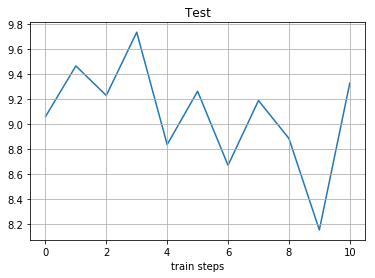

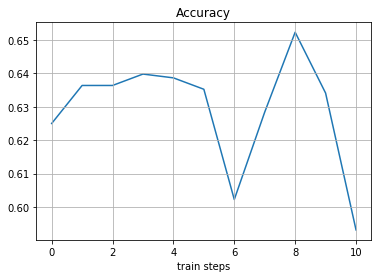

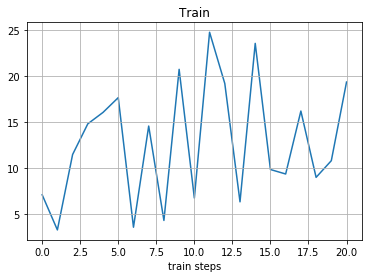

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(tokens.shape[0], hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, tokens.shape[0], tokens_f.shape[0] + 1, dropout_p=0.1).to(device)

train(dataset, test_batches, encoder1, attn_decoder1, 1)